In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import io, base64, os, json, re 
import pandas as pd
import numpy as np
import datetime
from random import randint
import requests
import time  as _time
from IPython.display import HTML
from datetime import datetime

In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
import yfinance as yf

# Part 1. Geometric Brownian Motion

## What is Geometric Brownian Motion?
This is an abstract concept so I want to explain what GBM is all about.

Brownian motion comes from physics. It describes the random movement of particles in a substance. A Wiener process is a one-dimentional Brownian motion. It’s named after Norbert Wiener who won a Nobel Prize studying one-dimentional Brownian motions.

The Wiener process features prominently in quantitative finance because of some useful mathemetical properties.

The GBM is a continuous-time stochastic process where where the log of the random variable follows the Wiener process with drift.

What?

It’s a data series that trends up or down through time with a defined level of volatility.

And it’s perfect for simulating stock prices.

## Set the input parameters
To simulate stock prices, we need some input parameters. Start by defining the initial stock price, s0. Then sigma which is the percentage volatility. Finally, mu (drift), which determine the overall trend.

Setup the simulation with 1,000 simulation paths. delta refers to the time step. I want to model a new stock price every day so I use 1/252 to represent 1 day in 252 trading days. The length of the simulation is 5 years.

In [5]:
# setup params for brownian motion
s0 = 131.00
sigma = 0.25
mu = 0.35

# setup the simulation
paths = 1000
delta = 1.0/252.0
time = 252 * 5

## Build the functions
The first step is to build a function that returns a Wiener process. This function returns a 2-dimentional array with 1,260 rows and 1,000 columns. Each row is a day and each column is a simulation path.

In [6]:
def wiener_process(delta, sigma, time, paths):
    """Returns a Wiener process
    
    Parameters
    ----------
    delta : float
        The increment to downsample sigma
    sigma : float
        Percentage volatility
    time : int
        Number of samples to create
    paths : int
        Number of price simulations to create
    
    Returns
    -------
    wiener_process : np.ndarray
    
    Notes
    -----
    This method returns a Wiener process. 
    The Wiener process is also called Brownian 
    motion. For more information about the 
    Wiener process check out the Wikipedia 
    page: http://en.wikipedia.org/wiki/Wiener_process
    """

    # return an array of samples from a normal distribution
    return sigma * np.random.normal(loc=0, scale=np.sqrt(delta), size=(time, paths))

Next, I define a function that creates the GBM returns.

In [7]:
def gbm_returns(delta, sigma, time, mu, paths):
    """Returns from a Geometric brownian motion
    
    Parameters
    ----------
    delta : float
        The increment to downsample sigma
    sigma : float
        Percentage volatility
    time : int
        Number of samples to create
    mu : float
        Percentage drift
    paths : int
        Number of price simulations to create
    
    Returns
    -------
    gbm_returns : np.ndarray
    
    Notes
    -----
    This method constructs random Geometric Brownian 
    Motion (GBM).
    """
    process = wiener_process(delta, sigma, time, paths)
    return np.exp(
        process + (mu - sigma**2 / 2) * delta
    )

Finally, I prepend a row of 1s to the returns array and multiply the starting stock price by the cumulative product of the GBM returns to produce the price paths.

In [8]:
def gbm_levels(s0, delta, sigma, time, mu, paths):
    """Returns price paths starting at s0
    
    Parameters
    ----------
    s0 : float
        The starting stock price
    delta : float
        The increment to downsample sigma
    sigma : float
        Percentage volatility
    time : int
        Number of samples to create
    mu : float
        Percentage drift
    paths : int
        Number of price simulations to create
    
    Returns
    -------
    gbm_levels : np.ndarray
    """
    returns = gbm_returns(delta, sigma, time, mu, paths)

    stacked = np.vstack([np.ones(paths), returns])
    return s0 * stacked.cumprod(axis=0)

## Visualize the results
I want to demonstrate two examples.

The first example simulates 1,000 price paths over 5 years. It starts at a price of 131 with 25% annualized volatility and 35% average return per year. This is the volatility and return of Apple in 2021.

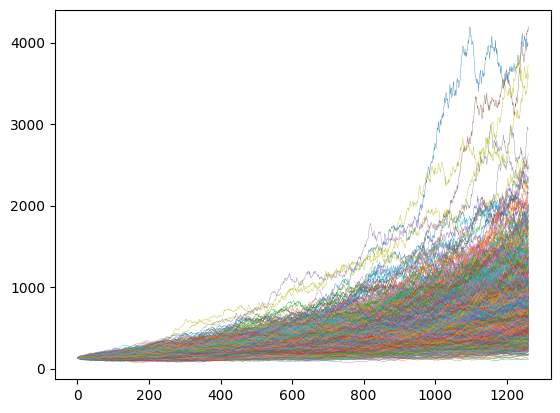

In [9]:
price_paths = gbm_levels(s0, delta, sigma, time, mu, paths)
plt.plot(price_paths, linewidth=0.25)
plt.show()

As you might expect, a 35% drift causes most price paths to increase from from the initial price. In fact we can test exactly how many have increased from the initial price.

In [10]:
len(price_paths[-1, price_paths[-1, :] > s0])

998

999 of the 1,000 samples have increased.

In the second example I set the drift to 0.0.

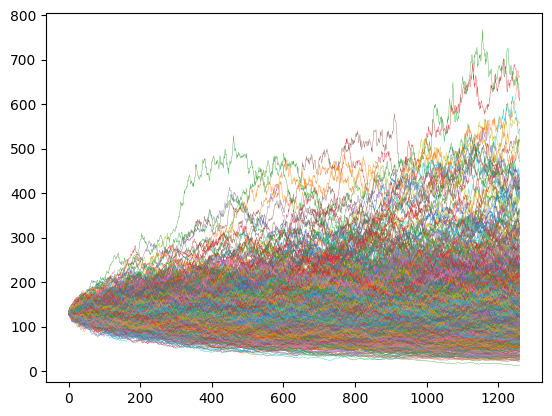

In [11]:
price_paths = gbm_levels(s0, delta, sigma, time, 0.0, paths)
plt.plot(price_paths, linewidth=0.25)
plt.show()

And I get a much different picture.

Only 402 prices end up higher than the original price.

Spend some time and play around with the variables. What happens if you double volatility? What happens if you set mu to a negative number?

# Part 2: Predicting NIFTY 50 index

In [14]:
from pandas_datareader import data as pdr
yf.pdr_override() # <== that's all it takes :-)

stockdata = pdr.get_data_yahoo(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = "^NSEI",
                             #tickers = "SPY AAPL MSFT",    !!!!!! to get multiple stocks at once

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = None,
    
        start='2020-06-01', end='2021-5-31',

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )

[*********************100%%**********************]  1 of 1 completed


In [15]:
stockdata

,Open,High,Low,Close,Volume
Date,,,,,
2020-06-01,9726.849609,9931.599609,9706.950195,9826.150391,794200
2020-06-02,9880.849609,9995.599609,9824.049805,9979.099609,770200
2020-06-03,10108.299805,10176.200195,10035.549805,10061.549805,794700
2020-06-04,10054.250000,10123.849609,9944.250000,10029.099609,775100
2020-06-05,10093.799805,10177.799805,10040.750000,10142.150391,987100
...,...,...,...,...,...
2021-05-24,15211.349609,15256.250000,15145.450195,15197.700195,579800
2021-05-25,15291.750000,15293.849609,15163.400391,15208.450195,441500
2021-05-26,15257.049805,15319.900391,15194.950195,15301.450195,384000


In [16]:
prices=pd.DataFrame([stockdata.index, stockdata.Close], ['Date', 'Close'])

In [17]:
prices=prices.T

In [18]:
prices

,Date,Close
0,2020-06-01,9826.150391
1,2020-06-02,9979.099609
2,2020-06-03,10061.549805
3,2020-06-04,10029.099609
4,2020-06-05,10142.150391
...,...,...
244,2021-05-24,15197.700195
245,2021-05-25,15208.450195
246,2021-05-26,15301.450195
247,2021-05-27,15337.849609


# plot of prices

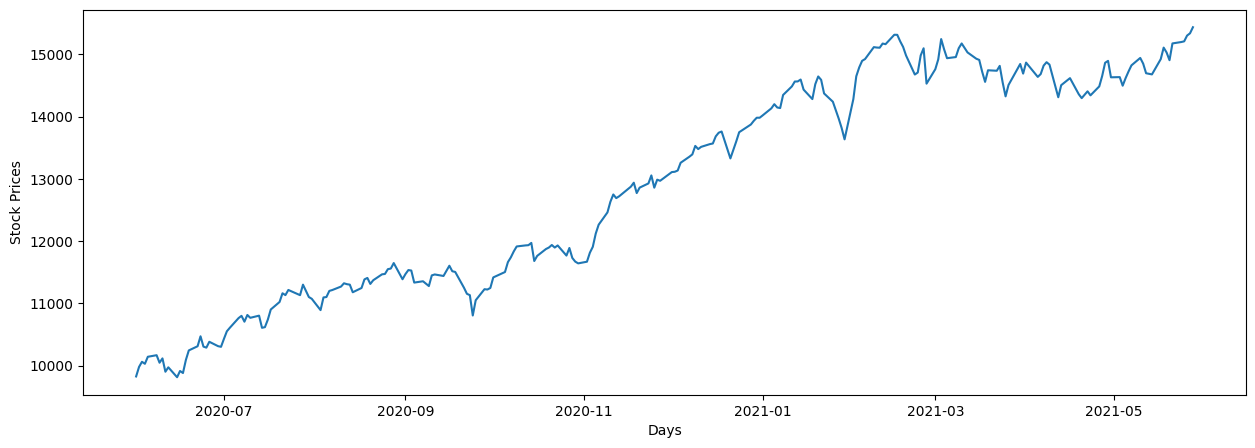

In [25]:
plt.figure(figsize = (15, 5))
plt.plot(prices['Date'], prices['Close'])
plt.xlabel('Days')
plt.ylabel('Stock Prices')
plt.show()

using 12mo data to predict future, so So is the current(initial) price

## Simulating NIFTY 50 index

[*********************100%%**********************]  1 of 1 completed


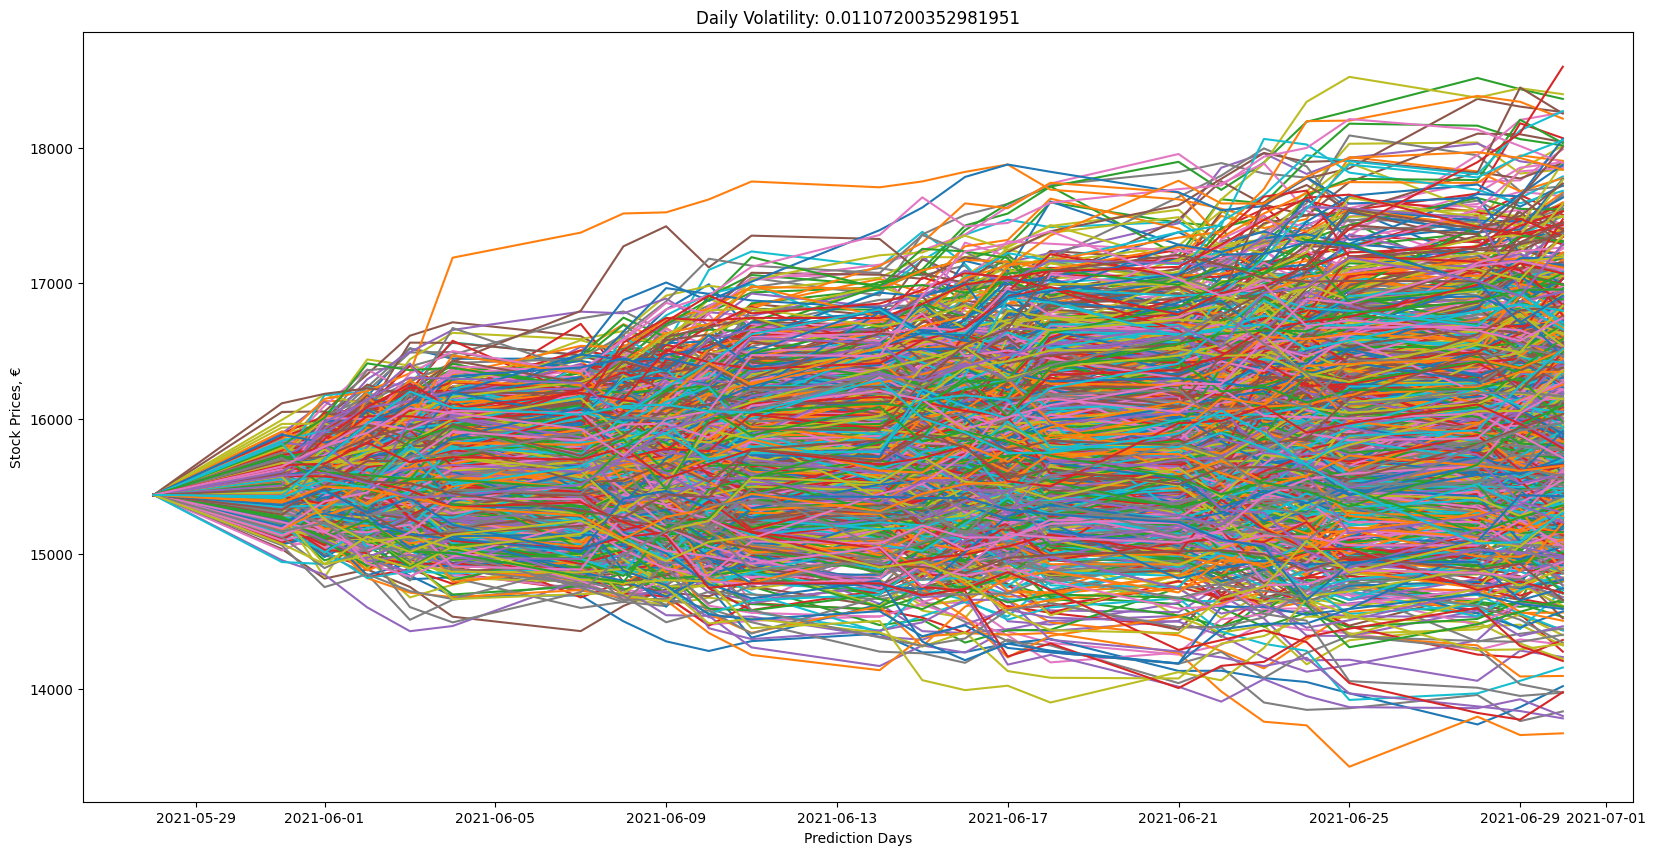

In [27]:
stockdata = pdr.get_data_yahoo(
            tickers = "^NSEI",
            period = None,
            start='2020-5-30', 
            end='2021-5-31',
            interval = "1d",
            group_by = 'ticker',
            auto_adjust = True,
            prepost = True,
            threads = True,
            proxy = None
        )
    
prices=pd.DataFrame([stockdata.index, stockdata.Close], ['Date', 'Close'])
prices=prices.T
    
So = prices.loc[prices.shape[0] - 1, "Close"]
dt = 1
pred_end_date = '2021-06-30 03:45:00'
start_date = str(prices['Date'][0])
end_date = str(prices['Date'].iloc[-1])
n_of_wkdays = pd.date_range(start = pd.to_datetime(end_date, 
                  format = "%Y-%m-%d %H:%M:%S") + pd.Timedelta('1 days'), 
                  end = pd.to_datetime(pred_end_date, 
                  format = "%Y-%m-%d %H:%M:%S")).to_series(
                  ).map(lambda x: 
                  1 if x.isoweekday() in range(1,6) else 0).sum()
T = n_of_wkdays
N = T / dt
t = np.arange(1, int(N) + 1)
returns = (prices.loc[1:, 'Close'] - \
              prices.shift(1).loc[1:, 'Close']) / \
              prices.shift(1).loc[1:, 'Close']
mu = np.mean(returns)
sigma = np.std(returns)
scen_size = 1000
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}
drift = (mu - 0.5 * sigma**2) * t
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}
S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)]) 
S = np.hstack((np.array([[So] for scen in range(scen_size)]), S))
plt.figure(figsize = (20,10))
means = []
devs = []
means.append(mu)
devs.append(sigma)

for i in range(scen_size):
    plt.title("Daily Volatility: " + str(sigma))
    plt.plot(pd.date_range(start = prices["Date"].max(), 
                    end = pred_end_date, freq = 'D').map(lambda x:
                    x if x.isoweekday() in range(1, 6) else np.nan).dropna(), S[i, :])
    plt.ylabel('Stock Prices, €')
    plt.xlabel('Prediction Days')

plt.show()

# Part 3: Exercise

## Problem (a) (2 point) Using the yfinance library, download and plot the adjusted close price of Vingroup stock (VIC.VN) from Nov 11, 2022 to Nov 10, 2023

In [56]:
# Your code goes here
from pandas_datareader import data as pdr
yf.pdr_override() 

stockdata = pdr.get_data_yahoo(  
        tickers = "VIC.VN",
        period = None,
        start='2022-11-11', end='2023-11-10',
        interval = "1d",
        group_by = 'ticker',
        auto_adjust = True,
        prepost = True,
        threads = True,
        proxy = None
    )

In [ ]:
stockdata

In [ ]:
prices = pd.DataFrame([stockdata.index, stockdata.Close], ['Date', 'Close'])
prices = prices.T
prices

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(prices['Date'], prices['Close'])
plt.xlabel('Days')
plt.ylabel('Close prices')
plt.show()

## Problem (b) (2 point) Sử dụng dữ liệu trong Problem (a), tính mu, sigma, drift của quá trình ngẫu nhiên từ giá cổ phiếu VIC

In [57]:
# Your code goes here
So = prices.loc[prices.shape[0] - 1, "Close"]
dt = 1
pred_end_date = '2023-12-09'
start_date = str(prices['Date'][0])
end_date = str(prices['Date'].iloc[-1])
n_of_wkdays = pd.date_range(start = pd.to_datetime(end_date, 
                  format = "%Y-%m-%d %H:%M:%S") + pd.Timedelta('1 days'), 
                  end = pd.to_datetime(pred_end_date, 
                  format = "%Y-%m-%d %H:%M:%S")).to_series(
                  ).map(lambda x: 
                  1 if x.isoweekday() in range(1,6) else 0).sum()
T = n_of_wkdays
N = T / dt
t = np.arange(1, int(N) + 1)
returns = (prices.loc[1:, 'Close'] - \
              prices.shift(1).loc[1:, 'Close']) / \
              prices.shift(1).loc[1:, 'Close']
mu = np.mean(returns)
sigma = np.std(returns)
drift = (mu - 0.5 * sigma**2) * t

In [ ]:
print(mu)
print(sigma)
print(drift)

## Problem (c) (4 point) Using 1000 realizations (scen_size), plot the price of VIC from Nov 13, 2023 to Dec 12, 2023

In [58]:
# Your code goes here
scen_size = 1000
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}
S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)]) 
S = np.hstack((np.array([[So] for scen in range(scen_size)]), S))
plt.figure(figsize = (20,10))
means = []
devs = []
means.append(mu)
devs.append(sigma)

for i in range(scen_size):
    plt.title("Daily Volatility: " + str(sigma))
    plt.plot(pd.date_range(start = prices["Date"].max(), 
                    end = pred_end_date, freq = 'D').map(lambda x:
                    x if x.isoweekday() in range(1, 6) else np.nan).dropna(), S[i, :])
    plt.ylabel('Stock Prices, €')
    plt.xlabel('Prediction Days')


## Problem (d) (1 point) What is the probability that VIC price will be greater or equal 50K when the market closes on Dec 12, 2023

In [59]:
# Your code goes here
threshold_price = 50000
num_cases = 0
for i in range(scen_size):
    final_price = S[i, -1]
    if final_price >= threshold_price:
        num_cases += 1
probability = num_cases / scen_size
print("Probability that VIC price will be greater or equal to 50K on Dec 12, 2023:", probability)

## Problem (e) (1 point) What is the probability that VIC price will be smllaler or equal 40K when the market closes on Dec 12, 2023

In [ ]:
threshold_price_smaller = 40000
num_cases_smaller = 0
for i in range(scen_size):
    final_price_smaller = S[i, -1]
    if final_price_smaller <= threshold_price_smaller:
        num_cases_smaller += 1
probability_smaller = num_cases_smaller / scen_size
print("Probability that VIC price will be smaller or equal to 40K on Dec 12, 2023:", probability_smaller)